# Coresets via Bilevel Optimization
This notebook containts a simple demo on how generate coresets with the library. This is showcased on a toy regression problem and on MNIST.


## Regression
Let us solve a rigde regression problem in 1D on a random subset of the data, where the underlying true model is a sine function. We will first work in the feature space corresponding to 7th order polynomials.


MSE 60.17782433683584


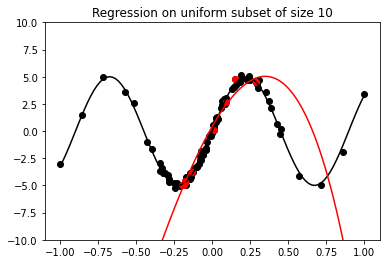

interactive(children=(IntSlider(value=10, description='subset_size', max=40, min=5), Output()), _dom_classes=(…

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
import bilevel_coreset
import loss_utils
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

np.random.seed(0)

# generate data
lim = 1
x = np.random.randn(85) * 0.2
x = x[np.logical_and(x <= lim, x >= -lim)]
x_linspace = np.linspace(-lim, lim, num=15)
x = np.concatenate((x, x_linspace))
x = x.reshape(-1, 1)

true_fn = lambda x: 5 * np.sin(x * 7)
y = true_fn(x.reshape(-1)) + 0.25 * np.random.randn(x.shape[0])

# set the regularizer
reg = 1e-3

# map X to 5-th degree poly features
poly_features = PolynomialFeatures(7)
x_features = poly_features.fit_transform(x)


def solve_regression(X, y):
    return np.linalg.pinv(X.T.dot(X) + reg * np.eye(X.shape[1])).dot(X.T).dot(y)


def plot_solution(theta_hat, x_chosen, y_chosen, title=''):
    x_linspace = np.linspace(-lim, lim, num=100)
    y_linspace = true_fn(x_linspace)
    plt.plot(x_linspace, y_linspace, c='black')
    x_lin_transf = poly_features.transform(x_linspace.reshape(-1, 1))
    plt.plot(x_linspace, x_lin_transf.dot(theta_hat), c='red')
    plt.scatter(x, y, c='black')
    plt.scatter(x_chosen, y_chosen, c='red')
    plt.ylim(-10, 10)
    plt.title(title)

def solve_uniform(subset_size):
    # sample subset_size points uniformly at random and solve the regression
    chosen_inds = np.random.choice(x.shape[0], subset_size, replace=False)
    theta_hat = solve_regression(x_features[chosen_inds], y[chosen_inds])
    plot_solution(theta_hat, x[chosen_inds], y[chosen_inds], 'Regression on uniform subset of size {}'.format(subset_size))
    print('MSE', np.mean((x_features.dot(theta_hat) - y) ** 2))
    
solve_uniform(10)
interact(solve_uniform, subset_size=widgets.IntSlider(min=5, max=40, step=1, value=10));

Now we solve the subset selection with our coreset selection method. For this demo we simply use unweighted coreset points by setting the number of outer iterations to 1. Notice how we can achieve much lower MSE with coresets compared to uniform subsamples with the same size.

In [ ]:
poly_kernel = lambda x1, x2: np.dot(poly_features.transform(x1), poly_features.transform(x2).T)

bc = bilevel_coreset.BilevelCoreset(outer_loss_fn=loss_utils.weighted_mse,
                                    inner_loss_fn=loss_utils.weighted_mse, out_dim=1, max_outer_it=1,
                                    inner_lr=0.25, max_inner_it=500, logging_period=100)
coreset_inds, _ = bc.build_with_representer_proxy_batch(x, y.reshape(-1, 1), 40, kernel_fn_np=poly_kernel,
                                                        cache_kernel=True, start_size=3, inner_reg=reg)

def solve_coreset(subset_size):
    chosen_inds = coreset_inds[:subset_size]
    theta_hat = solve_regression(x_features[chosen_inds], y[chosen_inds])
    plot_solution(theta_hat, x[chosen_inds], y[chosen_inds], 'Regression on coreset of size {}'.format(subset_size))
    print(subset_size, 'MSE', np.mean((x_features.dot(theta_hat) - y) ** 2))

solve_coreset(10)
interact(solve_coreset, subset_size=widgets.IntSlider(min=5, max=30, step=1, value=10));

10 MSE 2.9905574503191024


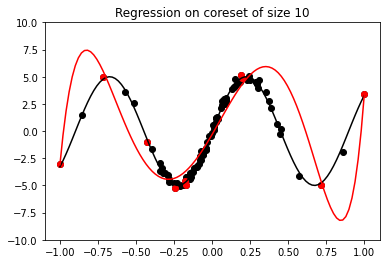

interactive(children=(IntSlider(value=10, description='subset_size', max=30, min=5), Output()), _dom_classes=(…